# Exploring Simple Network Architectures

In [ ]:
%load_ext autoreload
%autoreload 2

In [1]:
import datetime as dt
import random

import numpy as np
import tensorflow as tf
import keras
from keras import layers

from aegomoku.game_data import read_training_data

In [2]:
BOARD_SIZE=15
filename = "rawdata.pickle"
examples = read_training_data(filename, BOARD_SIZE)
len(examples), len(examples[0]), examples[0][0].shape

(20320, 3, (17, 17, 3))

In [3]:
np.array(examples[0][1]).shape

(225,)

In [4]:
inputs = keras.Input(shape=(17, 17, 3), name="inputs")

In [5]:
first = layers.Conv2D(
    name="initial",
    filters=256, kernel_size=11,
    kernel_initializer=tf.random_normal_initializer(),
    bias_initializer=tf.random_normal_initializer(),
    activation=tf.nn.elu,
    padding='same')

In [6]:
policy_aggregate = layers.Conv2D(
    name="policy_aggregator",
    filters=1, kernel_size=1,
    kernel_initializer=tf.random_normal_initializer(),
    bias_initializer=tf.random_normal_initializer(),
    activation=tf.nn.relu,
    padding='same')

In [7]:
peel = layers.Conv2D(
    name="border_off",
    filters=1, kernel_size=(3, 3),
    kernel_initializer=tf.constant_initializer([[0., 0., 0.], [0., 1., 0.], [0., 0., 0.]]),
    bias_initializer=tf.constant_initializer(0.),
    padding='valid',
    trainable=False)

In [8]:
x1 = first(inputs)
x2 = policy_aggregate(x1)
y = peel(x2)
flatten = layers.Flatten()(y)
softmax = layers.Softmax()(flatten)
model = keras.Model(inputs=inputs, outputs=softmax)
model.compile()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 17, 17, 3)]       0         
                                                                 
 initial (Conv2D)            (None, 17, 17, 256)       93184     
                                                                 
 policy_aggregator (Conv2D)  (None, 17, 17, 1)         257       
                                                                 
 border_off (Conv2D)         (None, 15, 15, 1)         10        
                                                                 
 flatten (Flatten)           (None, 225)               0         
                                                                 
 softmax (Softmax)           (None, 225)               0         
                                                                 
Total params: 93,451
Trainable params: 93,441
Non-trainable p

2022-08-07 19:56:53.824602: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-07 19:56:53.825329: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-07 19:56:53.830903: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-07 19:56:53.831553: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-07 19:56:53.832378: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from S

In [61]:
n = random.randint(0, 200)
sample = np.expand_dims(examples[n][0], axis=0).astype(float)
p = model(sample)
print((np.squeeze(p)*999).astype(np.uint8))

[4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 5 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 5 4 5 5 4 5 4 4 4 4 4 4 4 5 4 5 4 4 4 4 5 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 5 4 4 4 4 4 4 4
 4 4 4]


In [11]:
policy_loss = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

In [12]:
def create_dataset(data, batch_size=1024):
    subset = data
    x_train = np.asarray([t[0] for t in subset], dtype=float)
    pi_train = np.asarray([t[1] for t in subset])
    v_train = np.asarray([t[2] for t in subset])
    x_train_ds = tf.data.Dataset.from_tensor_slices(x_train).batch(batch_size)
    pi_train_ds = tf.data.Dataset.from_tensor_slices(pi_train).batch(batch_size)
    v_train_ds = tf.data.Dataset.from_tensor_slices(v_train).batch(batch_size)
    all_train_ds = tf.data.Dataset.zip((x_train_ds, pi_train_ds, v_train_ds))
    all_train_ds = all_train_ds.shuffle(buffer_size=batch_size)
    return all_train_ds

In [13]:
metric = tf.keras.metrics.Mean('train_loss', dtype=tf.float32)

def train(train_examples, epochs_per_train=100, report_every=100):
    current_time = dt.datetime.now().strftime("%Y%m%d-%H%M%S")
    train_log_dir = 'logs/gradient_tape/' + current_time + '/train'
    train_summary_writer = tf.summary.create_file_writer(train_log_dir)

    all_train_ds = create_dataset(train_examples)

    for epoch in range(epochs_per_train):
        for x_train, pi_train, _ in all_train_ds:
            train_step(x_train, pi_train)
        with train_summary_writer.as_default():
            tf.summary.scalar('loss', metric.result(), step=epoch)

        if epoch % report_every == 1:
            print(f'Epoch: {epoch}, Training: {metric.result()}')

    print(f'Epochs: {epochs_per_train}, Loss: {metric.result()}')

    metric.reset_states()

@tf.function
def train_step(x, pi_y):
    with tf.GradientTape() as tape:
        probs = model(x, training=True)
        total_loss = policy_loss(pi_y, probs)

    grads = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    metric(total_loss)

In [15]:
N = 2000
train(examples[:N], epochs_per_train=2000, report_every=100)

Epoch: 1, Training: 0.5799115896224976
Epoch: 101, Training: 0.5785767436027527
Epoch: 201, Training: 0.5778980851173401
Epoch: 301, Training: 0.5766984224319458
Epoch: 401, Training: 0.5757347345352173
Epoch: 501, Training: 0.574958860874176
Epoch: 601, Training: 0.5741463303565979
Epoch: 701, Training: 0.573319673538208
Epoch: 801, Training: 0.572691798210144
Epoch: 901, Training: 0.5721133947372437
Epoch: 1001, Training: 0.5714694261550903
Epoch: 1101, Training: 0.5709639191627502
Epoch: 1201, Training: 0.5704563856124878
Epoch: 1301, Training: 0.5699402093887329
Epoch: 1401, Training: 0.5695086717605591
Epoch: 1501, Training: 0.5690987706184387
Epoch: 1601, Training: 0.568703293800354
Epoch: 1701, Training: 0.5682902932167053
Epoch: 1801, Training: 0.5679441690444946
Epoch: 1901, Training: 0.567600667476654
Epochs: 2000, Loss: 0.5672773122787476


n=3055
Next to play: WHITE
Value from WHITE's point of view: -0.7970358847724879
Next to play: WHITE
Value from WHITE's point of view: 0.0


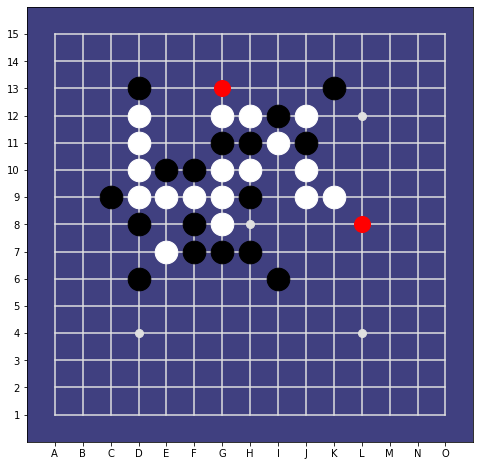

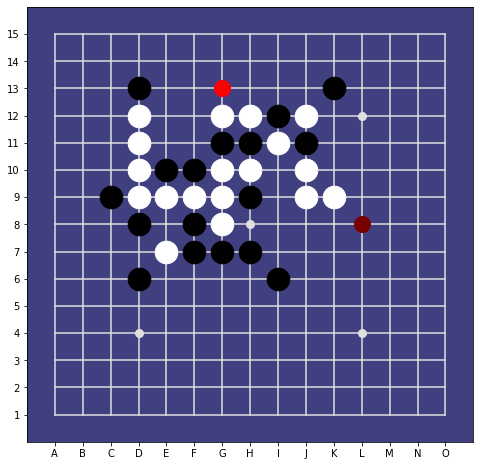

In [34]:
from aegomoku.utils import analyse_example

n = random.randint(N, 2*N)
sample = np.expand_dims(examples[n][0], axis=0).astype(float)
p_ = model(sample)
s, p, _ = examples[n]
example = (s, list(p_.numpy()), 0.0)
print(f"n={n}")
analyse_example(BOARD_SIZE, examples[n])
analyse_example(BOARD_SIZE, example)